In [1]:
%reload_ext autoreload
%autoreload 2

import os
import pickle

import numpy as np
import pandas as pd
from numpyro.diagnostics import hpdi

from hbmep.config import Config
from hbmep.model.utils import Site as site

from paper.utils import setup_logging
from constants import (
    TOML_PATH,
    DATA_PATH,
    INFERENCE_FILE
)

from core__midline_lateral import _process_data
from core__midline_lateral import BUILD_DIR



In [2]:
src = os.path.join(BUILD_DIR, INFERENCE_FILE)
with open(src, "rb") as f:
    model, mcmc, posterior_samples_ = pickle.load(f)



An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [8]:
df = pd.read_csv(DATA_PATH)
df = _process_data(df=df, ground=True)

df, encoder_dict = model.load(df=df)


In [9]:
encoder_dict["laterality"].inverse_transform(np.array([0, 1]))


array(['L', 'M'], dtype=object)

In [3]:
a_delta_loc = posterior_samples_["a_delta_loc"]
a_delta_loc.shape


(4000, 1, 6)

In [4]:
(a_delta_loc > 0).mean(axis=0)


array([[0.111  , 0.319  , 0.05775, 0.10375, 0.3825 , 0.04675]])

In [5]:
a_delta_loc_hdi = hpdi(a_delta_loc, .95)
a_delta_loc_hdi[:, 0, :]


array([[-30.65826642, -21.59349071, -36.04624258, -30.27119177,
        -23.7810925 , -31.61025418],
       [  6.65233224,  16.19450274,   2.93655361,   5.95707573,
         20.82358954,   3.67900528]])

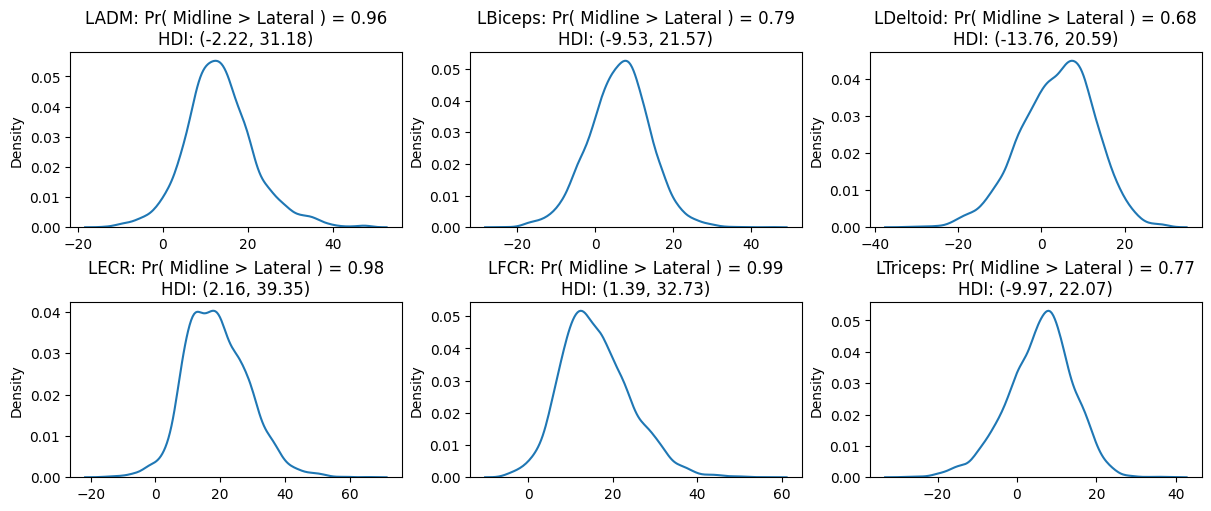

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns


nrows, ncols = 2, 3
fig, axes = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(ncols * 4, nrows * 2.5),
    constrained_layout=True,
    squeeze=False
)

for i in range(model.n_response):
    ax = axes[i // ncols, i % ncols]
    samples = a_delta_loc[:, 0, i]
    sns.kdeplot(samples, ax=ax)
    ax.set_title(
        f"{model.response[i]}: Pr( Midline > Lateral ) = {np.mean(samples > 0):.2f}\n"
        f"HDI: ({a_delta_loc_hdi[0, 0, i]:.2f}, {a_delta_loc_hdi[1, 0, i]:.2f})"
    )
